# Optical spectra of core-shell Au-PNIPAM nanoparticles

# Initialize analysis

## Python framework

In [1]:
%run header

Loading import modules ...
  ... math, cmath (local)
  ... os, sys, types, importlib
  ... time, datetime
  ... ipyparallel as ipp
  ... numpy as np
  ... scipy as sp
      scipy.special (local, for Bessel functions)
      scipy.interpolate as interpolate
      scipy.signal as signal
  ... matplotlib
      matplotlib.pyplot as plt
      matplotlib.cm as cm
      matplotlib.pylab as pylab
  ... sympy
Defining fundamental constants ...
  ... Avogadro's number: 'AvogadroN'
  ... speed of light: 'cumfs','cnmfs'
  ... Planck's constant: 'heVfs','hbareVfs'
  ... electron rest mass: 'eMass0eVnmfs'
  ... permittivity of free space: 'eps0enmV'
Loading analysis codes ... 
  ... refractive index functions loaded:
       Au, Ag, SiO2, ITO, ZnO, H2O, 
       ethanol, CS2, benzene, toluene, 
       chloroform, methanol, butanol, 
       propanol
  ... Mie functions loaded
Ready player one.


## Parallelization

In [20]:
%run header_parallel
%px %run header

Initializing cluster ...
   Client variable 'kernels'
   Cluster Direct View variable 'cluster'
   Variable 'nKernels' = 7
importing os on engine(s)
[stdout:0] 
Loading import modules ...
  ... math, cmath (local)
  ... os, sys, types, importlib
  ... time, datetime
  ... ipyparallel as ipp
  ... numpy as np
  ... scipy as sp
      scipy.special (local, for Bessel functions)
      scipy.interpolate as interpolate
      scipy.signal as signal
  ... matplotlib
      matplotlib.pyplot as plt
[stdout:1] 
Loading import modules ...
  ... math, cmath (local)
  ... os, sys, types, importlib
  ... time, datetime
  ... ipyparallel as ipp
  ... numpy as np
  ... scipy as sp
      scipy.special (local, for Bessel functions)
      scipy.interpolate as interpolate
      scipy.signal as signal
  ... matplotlib
      matplotlib.pyplot as plt
[stdout:2] 
Loading import modules ...
  ... math, cmath (local)
  ... os, sys, types, importlib
  ... time, datetime
  ... ipyparallel as ipp
  ... numpy as np


# Mie theory: Au-polymer core-shell NPs in water

## Abstract

* Multishell Mie-theory based on formulation by Moroz 2005:
  - http://dx.doi.org/10.1016/j.aop.2004.07.002
  - see "mie.py" for implementation details.
* Refractive index (RI) of gold using experimental tabulated data from Johnson & Christy (1972) with electron confinement effects (Bohren & Huffman 1998, Ch. 12).
  - It is known that J&C gives innaccurate peak positions for small NPs, off by roughly 3 nm. 
* Refractive index of shell at sampling wavelength of $\lambda_{\mathrm{SLS}}=632.8$ nm. For all other wavelengths, the refractive index dispersion is based on water: $$n(\lambda) = n_{\mathrm{H2O}}(\lambda) + [n_{\mathrm{shell}} - n_{\mathrm{H2O}}(\lambda_{\mathrm{SLS}})]$$
  - Refractive index of pure PNIPAM is estimated at 1.52.
  - Fully swollen shells in water (cold), RI is estimated 1.35-1.36.
  - Fully collapsed shells in water( hot), RI is estimated at 1.44-1.47.

In this notebook calculation: 
* Calculate 2 models
  - "bare-core" model = Au core surrounded by homogeneous RI
  - "core-shell" model = Au core surrounded by polymer hard-shell in water
* For one shell RI, at swollen conditions
  - Shell RI = 1.355
* For a range of Au core diameters
  - D = 15 - 100 nm
  - rCore = 7.5 - 50 nm
* For a range of shell diameters
  - D = 25 - 300 nm
  - rShell = 12.5 - 150
  - rShell $\geq$ rCore + 5
* Over the wavelength range 300 - 900 nm
* Returns the extinction cross section $C_{ext}$ in units of nm$^2$.

## First computations: bare cores

### Setup

#### Input parameter ranges

In [82]:
print("Input parameters for computation")
print("================================")

##-- parameter limits --##
# Max Mie expansion order
lmax = 5
# Wavelength range (vacuum)
wlMinnm, wlMaxnm, dwlnm = 300, 900, 1
wlListnm = np.arange(wlMinnm, wlMaxnm + dwlnm, dwlnm)


# Core size
rCoreMinnm, rCoreMaxnm = 7.5, 50
rCoreListnm = np.linspace(rCoreMinnm, rCoreMaxnm, 5)
rCoreListnm = np.round(2*rCoreListnm)/2 # round to nearest 0.5
drCorenm = np.mean(np.diff(rCoreListnm))


# report
np.set_printoptions(precision=3)
print('''\
* Mie expansion poles     = \"lmax\"         =  {0}
* vacuum wavelengths (nm) = \"wlListnm\"     =  [{1[0]:.1f} - {1[1]:.1f}] x {2:.1f}  ({3})
* core radius (nm)        = \"rCoreListnm\"  =  [{4[0]:.1f} - {4[1]:.1f}] x {5:.1f}  ({6})
'''.format(lmax, 
           wlListnm[[0,-1]], dwlnm, len(wlListnm), 
           rCoreListnm[[0,-1]], drCorenm, len(rCoreListnm) 
          )
)

Input parameters for computation
* Mie expansion poles     = "lmax"         =  5
* vacuum wavelengths (nm) = "wlListnm"     =  [300.0 - 900.0] x 1.0  (601)
* core radius (nm)        = "rCoreListnm"  =  [7.5 - 50.0] x 10.6  (5)



#### Input parameter array and computation algorithm definition

In [83]:
print('''\
Set up computation algorithm
============================ \
''')

# contruct parameter list
paramList = []
for rCorenm in rCoreListnm:
    for wlnm in wlListnm:
        paramList.append([
                lmax, wlnm, 
                rCorenm
            ])
paramArray = np.asarray(paramList)
# remove duplicate entries
def uniqueRows(a):
    b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
    _, idx = np.unique(b, return_index=True)
    unique_a = np.unique(b).view(a.dtype).reshape(-1, a.shape[1])
    return unique_a
paramArray = uniqueRows(paramArray)
Nsims = len(paramArray)

print('''\
* Input variable
    - \"paramArray\" = Mie theory inputs
    - type:\t{0}
    - size:\t{1}
* \"calcAtom\" input: 
    [   lmax, wlnm, 
        rCorenm  ] 
'''.format(type(paramArray), np.shape(np.asarray(paramArray)) )
     )


# Independent computing unit
def calcAtom(params):
    [   lmax, wlnm, 
        rCorenm
    ] = params
    lmax = int(lmax)
    
    # Au cores, J&C
    nAu = ri.nAuSc(wlnm, (4/3)*rCorenm)
    # Medium RI = water
    nmed = ( ri.nH2O(wlnm) ).real
    # vacuum wavenumber
    knm = 2*pi/wlnm
    
    # extinction cross section function
    def CExtFunc(nAu, rCorenm):
        ns = [nAu, nmed] 
        Rnms = [rCorenm]
        Cext = mie.Cext(lmax, ns, Rnms, knm)
        return Cext
    
    # Computations
    CextCore = CExtFunc(nAu, rCorenm)
    
    return [
        wlnm, 
        rCorenm, 
        CextCore 
    ]

# distribute atom definition to parallel kernels
try:
    cluster
except:
    0
else:
    cluster.push(dict(
            calcAtom = calcAtom
        ))

print('''\
* \"calcAtom\" output: 
    [   wlnm, 
        rCorenm, 
        CextCore 
    ] \
''')


Set up computation algorithm
* Input variable
    - "paramArray" = Mie theory inputs
    - type:	<class 'numpy.ndarray'>
    - size:	(3005, 3)
* "calcAtom" input: 
    [   lmax, wlnm, 
        rCorenm  ] 

* "calcAtom" output: 
    [   wlnm, 
        rCorenm, 
        CextCore 
    ] 


#### Test and time algorithm

In [84]:
print('''\
Test algorithm  
============== \
''')

testN = 15
testParamArray = paramArray[ np.random.randint(len(paramArray), size=testN) ]
testParam = testParamArray[0]
print('''\
* timing {2} computations 
  ({1:%Y-%m-%d %H:%M:%S}) ... \
'''.format(testParam, datetime.datetime.now(), testN ), end='')

startSec = time.time()
testReturnArray = np.asarray( list( map(calcAtom, testParamArray) ) )
endSec = time.time()
dtSec = endSec - startSec
atomTimeSec = dtSec/testN
testReturn = testReturnArray[0]
print(''' done ({1:%Y-%m-%d %H:%M:%S})
    - time elapsed          =  {2:.5e} sec
    - time per computation  =  {3:.5e} sec
* using params
    [   {4[0]:.0f}, {4[1]:.1f}, 
        {4[2]:.1f}  ] 
* returns
    [   {0[0]:.1f},  
        {0[1]:.1f}, 
        {0[2]:.5e}  ] \
'''.format(testReturn, datetime.datetime.now(), dtSec, atomTimeSec, testParam))

try: 
    cluster
except:
    estRunTimeSec = atomTimeSec*Nsims
    m, s = divmod(estRunTimeSec, 60)
    h, m = divmod(m, 60)
    print('''\
* Warning: No parallel clusters initialized, 
    proceeding with single thread compuation.
* Estimated run time
    {0} computations
      @ {1:.5e} sec/comp
    = {3:.3f} sec  =  {4:0>2.0f}:{5:0>2.0f}:{6:0>2.0f} (h:m:s) \
    '''.format(Nsims, atomTimeSec, 1, estRunTimeSec, h, m, s))
    
else: 
    Ncluster = nKernels
    estRunTimeSec = atomTimeSec*Nsims/Ncluster
    m, s = divmod(estRunTimeSec, 60)
    h, m = divmod(m, 60)
    print('''\
* Estimated run time
    {0} computations
      @ {1:.5e} sec/comp
      distributed over {2} engines 
    = {3:.3f} sec  =  {4:0>2.0f}:{5:0>2.0f}:{6:0>2.0f} (h:m:s) \
    '''.format(Nsims, atomTimeSec, Ncluster, estRunTimeSec, h, m, s))
    estRunTimeSec = atomTimeSec*Nsims/4
    m, s = divmod(estRunTimeSec, 60)
    h, m = divmod(m, 60)
    print('''\
* Virtual cores may not speed up computation!
    Assuming 3.5 \'real\' cores
    = {3:.3f} sec  =  {4:0>2.0f}:{5:0>2.0f}:{6:0>2.0f} (h:m:s) \
    '''.format(Nsims, atomTimeSec, Ncluster, estRunTimeSec, h, m, s))


Test algorithm  
* timing 15 computations 
  (2017-03-20 19:48:32) ...  done (2017-03-20 19:48:32)
    - time elapsed          =  1.56579e-02 sec
    - time per computation  =  1.04386e-03 sec
* using params
    [   5, 340.0, 
        18.0  ] 
* returns
    [   340.0,  
        18.0, 
        1.74003e+03  ] 
* Warning: No parallel clusters initialized, 
    proceeding with single thread compuation.
* Estimated run time
    3005 computations
      @ 1.04386e-03 sec/comp
    = 3.137 sec  =  00:00:03 (h:m:s)     


### Run & save matrix

#### Run full computation

In [85]:
print("Compute over all parameters")
print("===========================")

# Loop over parameters
print('* Computing ({:%Y-%m-%d %H:%M:%S}) ... '.format(datetime.datetime.now()), end='')
startSec = time.time()

try:
    nKernels
except:
    print('proceeding without parallelization ... ', end='')
    calcMapList = list(map(calcAtom, paramArray))
else:
    calcMapList = list(cluster.map_sync(calcAtom, paramArray))

endSec = time.time()
print('done ({:%Y-%m-%d %H:%M:%S})'.format(datetime.datetime.now()))
dtSec = endSec - startSec
DtSec = dtSec

try: 
    cluster
except:
    DtSec = dtSec
else:
    DtSec = dtSec*nKernels
    
m, s = divmod(dtSec, 60)
h, m = divmod(m, 60)

calcMapArray = np.asarray(calcMapList)
Ncalcs = calcMapArray.shape[0]

mieCextCoreArray = calcMapArray

print('''\
    - Run time = {0:.3f} sec  =  {4:0>2.0f}:{5:0>2.0f}:{6:0>2.2f} (h:m:s)
    - Time per simulation instance = {1:.3e} sec
* Return variable
    - \"mieCextCoreArray\" = Mie theory calculated extinction spectrum
    - type:\t{2}
    - size:\t{3} \
'''.format(dtSec, DtSec/Ncalcs, 
           type(mieCextCoreArray), 
           np.shape(np.asarray(mieCextCoreArray)),
           h, m, s
          )
     )

Compute over all parameters
* Computing (2017-03-20 19:48:32) ... proceeding without parallelization ... done (2017-03-20 19:48:34)
    - Run time = 1.189 sec  =  00:00:1.19 (h:m:s)
    - Time per simulation instance = 3.958e-04 sec
* Return variable
    - "mieCextCoreArray" = Mie theory calculated extinction spectrum
    - type:	<class 'numpy.ndarray'>
    - size:	(3005, 3) 


#### Save results matrix to file (disabled)

In [86]:
saveFlag = False
if (saveFlag):
    print('''\
Save result to file  
=================== 
* Saving variable:\t\"mieCextCoreArray\" \
    ''')
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.npy'
    filename = (timestamp 
                + "_mie-Cext_core" 
                + exportFormat
                )
    print('* To file:\t\t'+filename)
    print('* Initiating ({:%Y-%m-%d %H:%M:%S}) ... '.format(datetime.datetime.now()), end='')
    np.save(filename, mieCextCoreArray)
    print('done ({:%Y-%m-%d %H:%M:%S})'.format(datetime.datetime.now()))
else:
    print('Disabled.')

Disabled.


### Load matrix from file (disabled)

In [87]:
loadFlag = False
if (loadFlag):
    print('''\
Load computation from file  
========================== \
    ''')
    filename = '20170320_mie-Cext_core.npy'

    print('* Importing file:\t'+filename)
    print('* As variable:\t\t\"mieCextCoreArray\"')
    print('* Initiating ({:%Y-%m-%d %H:%M:%S}) ... '.format(datetime.datetime.now()), end='')
    mieCextCoreArray = np.load(filename)
    print('done ({:%Y-%m-%d %H:%M:%S})'.format(datetime.datetime.now()))
else: print('Disabled.')

Disabled.


### Save results to text file

In [88]:
print('''\
Save result to file  
=================== 
* Saving results from:\t\"mieCextCoreArray\" \
''')
timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
exportFormat = '.txt'
filename = (timestamp 
            + "_mie-Cext_core" 
            + exportFormat
            )
print('* To file:\t\t'+filename)
print('* Columns:')
headerRow = 'Wavelength-nm'
for rCorenm in rCoreListnm:
    headerRow += ',\tCext-nm2_DiamCore={0:.0f}-nm'.format(2*rCorenm)
print('  '+headerRow)
print('* Initiating ({:%Y-%m-%d %H:%M:%S}) ... '.format(datetime.datetime.now()), end='')

exportTable = []
for wlnm in wlListnm:
    exportRow = [wlnm]
    for rCorenm in rCoreListnm:
        select = ( (mieCextCoreArray[:, 1] == rCorenm) 
                  & (mieCextCoreArray[:, 0] == wlnm) )
        exportElement = mieCextCoreArray[select][0,-1]
        exportRow.append(exportElement)
    exportTable.append(exportRow)
exportTable = np.array(exportTable)

np.savetxt(filename, exportTable, delimiter='\t', header=headerRow)

print('done ({:%Y-%m-%d %H:%M:%S})'.format(datetime.datetime.now()))

Save result to file  
* Saving results from:	"mieCextCoreArray" 
* To file:		20170320_mie-Cext_core.txt
* Columns:
  Wavelength-nm,	Cext-nm2_DiamCore=15-nm,	Cext-nm2_DiamCore=36-nm,	Cext-nm2_DiamCore=58-nm,	Cext-nm2_DiamCore=79-nm,	Cext-nm2_DiamCore=100-nm
* Initiating (2017-03-20 19:48:34) ... done (2017-03-20 19:48:34)


## Second computation: core-shell nanoparticles

### Setup

#### Input parameter ranges

In [66]:
print("Input parameters for computation")
print("================================")

##-- parameter limits --##
# Max Mie expansion order
lmax = 5
# Wavelength range (vacuum)
wlMinnm, wlMaxnm, dwlnm = 300, 900, 1
wlListnm = np.arange(wlMinnm, wlMaxnm + dwlnm, dwlnm)


# Core size
rCoreMinnm, rCoreMaxnm = 7.5, 50
rCoreListnm = np.linspace(rCoreMinnm, rCoreMaxnm, 5)
rCoreListnm = np.unique(np.round(2*rCoreListnm)/2) # round to nearest 0.5 nm
drCorenm = np.mean(np.diff(rCoreListnm))


# Shell size
rShellMinnm, rShellMaxnm = 12.5, 150
rShellListnm = np.linspace(rShellMinnm, rShellMaxnm, 5)
rShellListnm = np.unique(np.round(2*rShellListnm)/2) # round to nearest 0.5 nm
drShellnm = np.mean(np.diff(rShellListnm))


# Minimum thickness of the shell
thShellMinnm = 5


# Shell refractive index (RI)
nShellMin, nShellMax = 1.355, 1.355
nShellList = np.linspace(nShellMin, nShellMax, 5)
nShellList = np.unique(np.round(200*nShellList)/200) # round to nearest 0.005
dnShell = 0
if len(nShellList) > 1: dnShell = np.mean(np.diff(nShellList))


# report
np.set_printoptions(precision=3)
print('''\
* Mie expansion poles     = \"lmax\"         =  {0}
* vacuum wavelengths (nm) = \"wlListnm\"     =  [{1[0]:.1f} - {1[1]:.1f}] x {2:.1f}  ({3})
* core radius (nm)        = \"rCoreListnm\"  =  [{4[0]:.1f} - {4[1]:.1f}] x {5:.1f}  ({6})
* shell radius (nm)       = \"rShellListnm\" =  [{7[0]:.1f} - {7[1]:.1f}] x {8:.1f}  ({9})
* min. shell thick. (nm)  = \"thShellMinnm\" =  {13}
* shell RI                = \"nShellList\"   =  [{10[0]:.3f} - {10[1]:.3f}] x {11:.3f}  ({12})
'''.format(lmax, 
           wlListnm[[0,-1]], dwlnm, len(wlListnm), 
           rCoreListnm[[0,-1]], drCorenm, len(rCoreListnm) ,
           rShellListnm[[0,-1]], drShellnm, len(rShellListnm) ,
           nShellList[[0,-1]], dnShell, len(nShellList) ,
           thShellMinnm
          )
)

Input parameters for computation
* Mie expansion poles     = "lmax"         =  5
* vacuum wavelengths (nm) = "wlListnm"     =  [300.0 - 900.0] x 1.0  (601)
* core radius (nm)        = "rCoreListnm"  =  [7.5 - 50.0] x 10.6  (5)
* shell radius (nm)       = "rShellListnm" =  [12.5 - 150.0] x 34.4  (5)
* min. shell thick. (nm)  = "thShellMinnm" =  5
* shell RI                = "nShellList"   =  [1.355 - 1.355] x 0.000  (1)



#### Input parameter array and computation algorithm definition

In [67]:
print('''\
Set up computation algorithm
============================ \
''')

# contruct parameter list
paramList = []
for rCorenm in rCoreListnm:
    for nShell in nShellList:
        for rShellnm in rShellListnm:
            for wlnm in wlListnm:
                if rShellnm - rCorenm >= thShellMinnm:
                    paramList.append([
                            lmax, wlnm, 
                            rCorenm, 
                            rShellnm, nShell 
                        ])
paramArray = np.asarray(paramList)
# remove duplicate entries
def uniqueRows(a):
    b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
    _, idx = np.unique(b, return_index=True)
    unique_a = np.unique(b).view(a.dtype).reshape(-1, a.shape[1])
    return unique_a
paramArray = uniqueRows(paramArray)
Nsims = len(paramArray)

print('''\
* Input variable
    - \"paramArray\" = Mie theory inputs
    - type:\t{0}
    - size:\t{1}
* \"calcAtom\" input: 
    [   lmax, wlnm, 
        rCorenm, 
        rShellnm, nShell  ] 
'''.format(type(paramArray), np.shape(np.asarray(paramArray)) )
     )


# Independent computing unit
def calcAtom(params):
    [   lmax, wlnm, 
        rCorenm, 
        rShellnm, nShell 
    ] = params
    lmax = int(lmax)
    
    # Au cores, J&C
    nAu = ri.nAuSc(wlnm, (4/3)*rCorenm)
    # Medium RI = water
    nmed = ( ri.nH2O(wlnm) ).real 
    nmedRef = ( ri.nH2O(632.8) ).real
    # Shell RI, dispersion modeled on water
    nshell = np.real( nmed + (nShell - nmedRef) ).tolist()

    # vacuum wavenumber
    knm = 2*pi/wlnm
    
    # extinction cross section function
    def CExtFunc(nAu, rCorenm, rShellnm):
        ns = [nAu, nshell, nmed] 
        Rnms = [rCorenm, rShellnm]
        Cext = mie.Cext(lmax, ns, Rnms, knm)
        return Cext
    
    # Computations
    CextCoreShell = CExtFunc(nAu, rCorenm, rShellnm)
    
    return [
        wlnm, 
        rCorenm, 
        rShellnm, nShell, 
        CextCoreShell 
    ]

# distribute atom definition to parallel kernels
try:
    cluster
except:
    0
else:
    cluster.push(dict(
            calcAtom = calcAtom
        ))

print('''\
* \"calcAtom\" output: 
    [   wlnm, 
        rCorenm, 
        rShellnm, nShell, 
        CextCoreShell 
    ] \
''')


Set up computation algorithm
* Input variable
    - "paramArray" = Mie theory inputs
    - type:	<class 'numpy.ndarray'>
    - size:	(12020, 5)
* "calcAtom" input: 
    [   lmax, wlnm, 
        rCorenm, 
        rShellnm, nShell  ] 

* "calcAtom" output: 
    [   wlnm, 
        rCorenm, 
        rShellnm, nShell, 
        CextCoreShell 
    ] 


#### Test and time algorithm

In [68]:
print('''\
Test algorithm  
============== \
''')

testN = 100
testParamArray = paramArray[ np.random.randint(len(paramArray), size=testN) ]
testParam = testParamArray[0]
print('''\
* timing {2} computations 
  ({1:%Y-%m-%d %H:%M:%S}) ... \
'''.format(testParam, datetime.datetime.now(), testN ), end='')

startSec = time.time()
testReturnArray = np.asarray( list( map(calcAtom, testParamArray) ) )
endSec = time.time()
dtSec = endSec - startSec
atomTimeSec = dtSec/testN
testReturn = testReturnArray[0]
print(''' done ({1:%Y-%m-%d %H:%M:%S})
    - time elapsed          =  {2:.5e} sec
    - time per computation  =  {3:.5e} sec
* using params
    [   {4[0]:.0f}, {4[1]:.1f}, 
        {4[2]:.1f}, 
        {4[3]:.1f}, {4[4]:.3f}  ] 
* returns
    [   {0[0]:.1f},  
        {0[1]:.1f}, 
        {0[2]:.1f}, {0[3]:.3f}, 
        {0[4]:.5e}  ] \
'''.format(testReturn, datetime.datetime.now(), dtSec, atomTimeSec, testParam))

try: 
    cluster
except:
    estRunTimeSec = atomTimeSec*Nsims
    m, s = divmod(estRunTimeSec, 60)
    h, m = divmod(m, 60)
    print('''\
* Warning: No parallel clusters initialized, 
    proceeding with single thread compuation.
* Estimated run time
    {0} computations
      @ {1:.5e} sec/comp
    = {3:.3f} sec  =  {4:0>2.0f}:{5:0>2.0f}:{6:0>2.0f} (h:m:s) \
    '''.format(Nsims, atomTimeSec, 1, estRunTimeSec, h, m, s))
    
else: 
    Ncluster = nKernels
    estRunTimeSec = atomTimeSec*Nsims/Ncluster
    m, s = divmod(estRunTimeSec, 60)
    h, m = divmod(m, 60)
    print('''\
* Estimated run time
    {0} computations
      @ {1:.5e} sec/comp
      distributed over {2} engines 
    = {3:.3f} sec  =  {4:0>2.0f}:{5:0>2.0f}:{6:0>2.0f} (h:m:s) \
    '''.format(Nsims, atomTimeSec, Ncluster, estRunTimeSec, h, m, s))
    estRunTimeSec = atomTimeSec*Nsims/4
    m, s = divmod(estRunTimeSec, 60)
    h, m = divmod(m, 60)
    print('''\
* Virtual cores may not speed up computation!
    Assuming 3.5 \'real\' cores
    = {3:.3f} sec  =  {4:0>2.0f}:{5:0>2.0f}:{6:0>2.0f} (h:m:s) \
    '''.format(Nsims, atomTimeSec, Ncluster, estRunTimeSec, h, m, s))


Test algorithm  
* timing 100 computations 
  (2017-03-20 19:42:45) ...  done (2017-03-20 19:42:45)
    - time elapsed          =  6.68702e-02 sec
    - time per computation  =  6.68702e-04 sec
* using params
    [   5, 611.0, 
        50.0, 
        81.0, 1.355  ] 
* returns
    [   611.0,  
        50.0, 
        81.0, 1.355, 
        4.05893e+04  ] 
* Warning: No parallel clusters initialized, 
    proceeding with single thread compuation.
* Estimated run time
    12020 computations
      @ 6.68702e-04 sec/comp
    = 8.038 sec  =  00:00:08 (h:m:s)     


### Run & save matrix

#### Run full computation

In [69]:
print("Compute over all parameters")
print("===========================")

# Loop over parameters
print('* Computing ({:%Y-%m-%d %H:%M:%S}) ... '.format(datetime.datetime.now()), end='')
startSec = time.time()

try:
    nKernels
except:
    print('proceeding without parallelization ... ', end='')
    calcMapList = list(map(calcAtom, paramArray))
else:
    calcMapList = list(cluster.map_sync(calcAtom, paramArray))

endSec = time.time()
print('done ({:%Y-%m-%d %H:%M:%S})'.format(datetime.datetime.now()))
dtSec = endSec - startSec
DtSec = dtSec

try: 
    cluster
except:
    DtSec = dtSec
else:
    DtSec = dtSec*nKernels
    
m, s = divmod(dtSec, 60)
h, m = divmod(m, 60)

calcMapArray = np.asarray(calcMapList)
Ncalcs = calcMapArray.shape[0]

mieCextCoreShellArray = calcMapArray

print('''\
    - Run time = {0:.3f} sec  =  {4:0>2.0f}:{5:0>2.0f}:{6:0>2.2f} (h:m:s)
    - Time per simulation instance = {1:.3e} sec
* Return variable
    - \"mieCextCoreShellArray\" = Mie theory calculated extinction spectrum
    - type:\t{2}
    - size:\t{3} \
'''.format(dtSec, DtSec/Ncalcs, 
           type(mieCextCoreShellArray), 
           np.shape(np.asarray(mieCextCoreShellArray)),
           h, m, s
          )
     )

Compute over all parameters
* Computing (2017-03-20 19:42:55) ... proceeding without parallelization ... done (2017-03-20 19:43:02)
    - Run time = 7.278 sec  =  00:00:7.28 (h:m:s)
    - Time per simulation instance = 6.055e-04 sec
* Return variable
    - "mieCextCoreShellArray" = Mie theory calculated extinction spectrum
    - type:	<class 'numpy.ndarray'>
    - size:	(12020, 5) 


#### Save results matrix to file (disabled)

In [80]:
saveFlag = False
if (saveFlag):
    print('''\
Save result to file  
=================== 
* Saving variable:\t\"mieCextCoreShellArray\" \
    ''')
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.npy'
    filename = (timestamp 
                + "_mie-Cext_core-shell" 
                + exportFormat
                )
    print('* To file:\t\t'+filename)
    print('* Initiating ({:%Y-%m-%d %H:%M:%S}) ... '.format(datetime.datetime.now()), end='')
    np.save(filename, mieCextCoreShellArray)
    print('done ({:%Y-%m-%d %H:%M:%S})'.format(datetime.datetime.now()))
else:
    print('Disabled.')

Disabled.


### Load matrix from file (disabled)

In [81]:
loadFlag = False
if (loadFlag):
    print('''\
Load computation from file  
========================== \
    ''')
    filename = '20170320_mie-Cext_core-shell.npy'

    print('* Importing file:\t'+filename)
    print('* As variable:\t\t\"mieCextCoreShellArray\"')
    print('* Initiating ({:%Y-%m-%d %H:%M:%S}) ... '.format(datetime.datetime.now()), end='')
    mieCextCoreShellArray = np.load(filename)
    print('done ({:%Y-%m-%d %H:%M:%S})'.format(datetime.datetime.now()))
else:
    print('Disabled.')

Disabled.


### Save results to text files

In [52]:
print('''\
Save result to file  
=================== 
* Saving results from:\t\"mieCextCoreShellArray\" \
''')
timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
exportFormat = '.txt'
print('* Columns:')
headerRow = 'Wavelength-nm'
for rCorenm in rCoreListnm:
    headerRow += ',\tCext-nm2_DiamCore={0:.0f}-nm'.format(2*rCorenm)
print('  '+headerRow)
    
for rShellnm in rShellListnm:
    filename = (timestamp 
                + "_mie-Cext_core-shell_DiamShell=" 
                + str(int(round(2*rShellnm)))+'nm'
                + exportFormat
                )
    print('* To file:\n  + '+filename)
    print('    - Initiating ({:%Y-%m-%d %H:%M:%S}) ... '.format(datetime.datetime.now()), end='')

    exportTable = []
    for wlnm in wlListnm:
        exportRow = [wlnm]
        for rCorenm in rCoreListnm:
            select = ((mieCextCoreShellArray[:, 2] == rShellnm)
                      & (mieCextCoreShellArray[:, 1] == rCorenm) 
                      & (mieCextCoreShellArray[:, 0] == wlnm) )
            exportElement = mieCextCoreShellArray[select]
            if (len(exportElement) > 0):
                exportElement = exportElement[0,-1]
                exportRow.append(exportElement)
            else: exportRow.append(0)
        if (len(exportRow) > 1): exportTable.append(exportRow)
    exportTable = np.array(exportTable)

    np.savetxt(filename, exportTable, delimiter='\t', header=headerRow)

    print('done ({:%Y-%m-%d %H:%M:%S})'.format(datetime.datetime.now()))

Save result to file  
* Saving results from:	"mieCextCoreShellArray" 
* Columns:
  Wavelength-nm,	Cext-nm2_DiamCore=15-nm,	Cext-nm2_DiamCore=36-nm,	Cext-nm2_DiamCore=58-nm,	Cext-nm2_DiamCore=79-nm,	Cext-nm2_DiamCore=100-nm
* To file:
  + 20170320_mie-Cext_core-shell_DiamShell=25nm.txt
    - Initiating (2017-03-20 19:22:10) ... done (2017-03-20 19:22:10)
* To file:
  + 20170320_mie-Cext_core-shell_DiamShell=94nm.txt
    - Initiating (2017-03-20 19:22:10) ... done (2017-03-20 19:22:10)
* To file:
  + 20170320_mie-Cext_core-shell_DiamShell=162nm.txt
    - Initiating (2017-03-20 19:22:10) ... done (2017-03-20 19:22:11)
* To file:
  + 20170320_mie-Cext_core-shell_DiamShell=231nm.txt
    - Initiating (2017-03-20 19:22:11) ... done (2017-03-20 19:22:11)
* To file:
  + 20170320_mie-Cext_core-shell_DiamShell=300nm.txt
    - Initiating (2017-03-20 19:22:11) ... done (2017-03-20 19:22:11)


# Some plots

## Core spectra

### Efficiency

"mieCextCoreArray" format:
    [   wlnm, 
        rCorenm, 
        CextCore 
    ] 
Exported to:
 20170320_spectrum-efficiency_cores_85mm.pdf


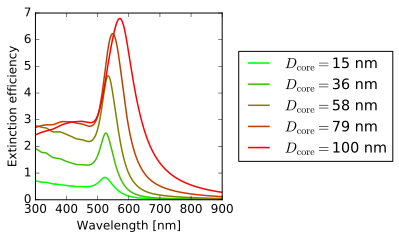

In [100]:
pylab.clf()

exportFlag = True

print('''\
\"mieCextCoreArray\" format:
    [   wlnm, 
        rCorenm, 
        CextCore 
    ] \
''')
mieArray = mieCextCoreArray

rCoreListnm = np.unique(mieArray[:,1])
colorList = cm.brg_r(np.linspace(0,0.5,len(rCoreListnm)))

xs, ys = [], []
colors, labels = [], []
for coreNum in range(len(rCoreListnm)):
    rCorenm = rCoreListnm[coreNum]
    color = colorList[coreNum]
    label = '$D_{\mathrm{core}} = $' + str(int(round(2*rCorenm))) + ' nm'
    subArray = mieArray[( mieArray[:,1] == rCorenm )]
    subArray = subArray[np.argsort( subArray[:,0] )]
    x, y = subArray[:,0], subArray[:,-1]
    y = y/(pi*rCorenm**2) # Efficiency = Cext-nm^2/(pi*r^2)
    xs.append(x), ys.append(y)
    colors.append(color), labels.append(label)

## Plot lines & set limits
nSets = len(xs)
for setNum in range(nSets):
    pylab.plot(xs[setNum], ys[setNum], 
               color=colors[setNum], label=labels[setNum], 
               linewidth=1.5)
x, y = [], []
for setNum in range(nSets):
    for i in range(len(xs[setNum])): 
        x.append(xs[setNum][i]); y.append(ys[setNum][i])
x, y = np.asarray(x), np.asarray(y)
xLimits = [np.amin(x), np.amax(x)]
yLimits = [np.amin(y), np.amax(y)]
dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])

pylab.xlabel('Wavelength [nm]')
pylab.ylabel('Extinction efficiency')
pylab.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## Save and display
if (exportFlag):
    fig = pylab.gcf()
    wmmList = [85]
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.pdf'
    identifier = '_spectrum-efficiency_cores'
    folder = ''
    for wmm in wmmList:
        fig.set_size_inches(wmm/25.4, wmm/25.4)
        fontSize = min([int(ceil(wmm/5.7)), 12])
        matplotlib.rcParams.update({'font.size': fontSize})
        for text in fig.texts:
            text.set_fontsize(fontSize)
        sizeName = '_' + str(wmm) + 'mm'
        filename = folder + timestamp + identifier + sizeName + exportFormat
        plt.savefig(filename, transparent=True); print("Exported to:\n", filename)
    matplotlib.rcParams['font.size'] = 12

plt.show()

### Cross section (nm$^2$)

"mieCextCoreArray" format:
    [   wlnm, 
        rCorenm, 
        CextCore 
    ] 
Exported to:
 20170320_spectrum-ext-nm2_cores_85mm.pdf


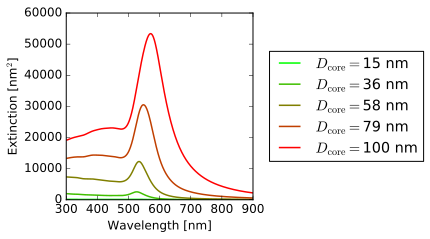

In [101]:
pylab.clf()

exportFlag = True

print('''\
\"mieCextCoreArray\" format:
    [   wlnm, 
        rCorenm, 
        CextCore 
    ] \
''')
mieArray = mieCextCoreArray

rCoreListnm = np.unique(mieArray[:,1])
colorList = cm.brg_r(np.linspace(0,0.5,len(rCoreListnm)))

xs, ys = [], []
colors, labels = [], []
for coreNum in range(len(rCoreListnm)):
    rCorenm = rCoreListnm[coreNum]
    color = colorList[coreNum]
    label = '$D_{\mathrm{core}} = $' + str(int(round(2*rCorenm))) + ' nm'
    subArray = mieArray[( mieArray[:,1] == rCorenm )]
    subArray = subArray[np.argsort( subArray[:,0] )]
    x, y = subArray[:,0], subArray[:,-1]
    xs.append(x), ys.append(y)
    colors.append(color), labels.append(label)

## Plot lines & set limits
nSets = len(xs)
for setNum in range(nSets):
    pylab.plot(xs[setNum], ys[setNum], 
               color=colors[setNum], label=labels[setNum], 
               linewidth=1.5)
x, y = [], []
for setNum in range(nSets):
    for i in range(len(xs[setNum])): 
        x.append(xs[setNum][i]); y.append(ys[setNum][i])
x, y = np.asarray(x), np.asarray(y)
xLimits = [np.amin(x), np.amax(x)]
yLimits = [np.amin(y), np.amax(y)]
dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])

pylab.xlabel('Wavelength [nm]')
pylab.ylabel('Extinction [nm$^2$]')
pylab.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## Save and display
if (exportFlag):
    fig = pylab.gcf()
    wmmList = [85]
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.pdf'
    identifier = '_spectrum-ext-nm2_cores'
    folder = ''
    for wmm in wmmList:
        fig.set_size_inches(wmm/25.4, wmm/25.4)
        fontSize = min([int(ceil(wmm/5.7)), 12])
        matplotlib.rcParams.update({'font.size': fontSize})
        for text in fig.texts:
            text.set_fontsize(fontSize)
        sizeName = '_' + str(wmm) + 'mm'
        filename = folder + timestamp + identifier + sizeName + exportFormat
        plt.savefig(filename, transparent=True); print("Exported to:\n", filename)
    matplotlib.rcParams['font.size'] = 12

plt.show()

### Normalized

"mieCextCoreArray" format:
    [   wlnm, 
        rCorenm, 
        CextCore 
    ] 
Exported to:
 20170320_spectrum-ext-norm_cores_85mm.pdf


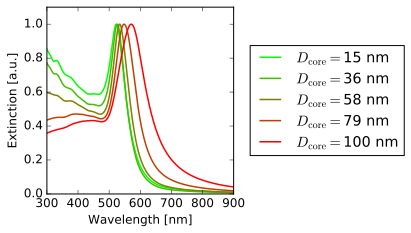

In [103]:
pylab.clf()

exportFlag = True

print('''\
\"mieCextCoreArray\" format:
    [   wlnm, 
        rCorenm, 
        CextCore 
    ] \
''')
mieArray = mieCextCoreArray

rCoreListnm = np.unique(mieArray[:,1])
colorList = cm.brg_r(np.linspace(0,0.5,len(rCoreListnm)))

xs, ys = [], []
colors, labels = [], []
for coreNum in range(len(rCoreListnm)):
    rCorenm = rCoreListnm[coreNum]
    color = colorList[coreNum]
    label = '$D_{\mathrm{core}} = $' + str(int(round(2*rCorenm))) + ' nm'
    subArray = mieArray[( mieArray[:,1] == rCorenm )]
    subArray = subArray[np.argsort( subArray[:,0] )]
    x, y = subArray[:,0], subArray[:,-1]
    y = y/max(y) # normalized
    xs.append(x), ys.append(y)
    colors.append(color), labels.append(label)

## Plot lines & set limits
nSets = len(xs)
for setNum in range(nSets):
    pylab.plot(xs[setNum], ys[setNum], 
               color=colors[setNum], label=labels[setNum], 
               linewidth=1.5)
x, y = [], []
for setNum in range(nSets):
    for i in range(len(xs[setNum])): 
        x.append(xs[setNum][i]); y.append(ys[setNum][i])
x, y = np.asarray(x), np.asarray(y)
xLimits = [np.amin(x), np.amax(x)]
yLimits = [np.amin(y), np.amax(y)]
dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])

pylab.ylim([0,1.1])

pylab.xlabel('Wavelength [nm]')
pylab.ylabel('Extinction [a.u.]')
pylab.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## Save and display
if (exportFlag):
    fig = pylab.gcf()
    wmmList = [85]
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.pdf'
    identifier = '_spectrum-ext-norm_cores'
    folder = ''
    for wmm in wmmList:
        fig.set_size_inches(wmm/25.4, wmm/25.4)
        fontSize = min([int(ceil(wmm/5.7)), 12])
        matplotlib.rcParams.update({'font.size': fontSize})
        for text in fig.texts:
            text.set_fontsize(fontSize)
        sizeName = '_' + str(wmm) + 'mm'
        filename = folder + timestamp + identifier + sizeName + exportFormat
        plt.savefig(filename, transparent=True); print("Exported to:\n", filename)
    matplotlib.rcParams['font.size'] = 12

plt.show()

## Core-shell spectra, $D_{\mathrm{core}} = 15$ nm

### Efficiency

"mieCextCoreShellArray" format:
    [   wlnm, 
        rCorenm, 
        rShellnm, nShell, 
        CextCoreShell 
    ] 
15 nm
Exported to:
 20170320_spectrum-efficiency_15-nm-core-shells_85mm.pdf


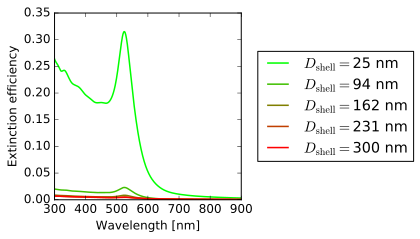

In [114]:
pylab.clf()

exportFlag = True

print('''\
\"mieCextCoreShellArray\" format:
    [   wlnm, 
        rCorenm, 
        rShellnm, nShell, 
        CextCoreShell 
    ] \
''')
mieArray = mieCextCoreShellArray

rCoreListnm = np.unique(mieArray[:,1])
rCorenm = rCoreListnm[0]
print(str(int(round(2*rCorenm))) + ' nm')
rShellListnm = np.unique(mieArray[:,2])
colorList = cm.brg_r(np.linspace(0,0.5,len(rShellListnm)))

xs, ys = [], []
colors, labels = [], []
for shellNum in range(len(rShellListnm)):
    rShellnm = rShellListnm[shellNum]
    color = colorList[shellNum]
    label = '$D_{\mathrm{shell}} = $' + str(int(round(2*rShellnm))) + ' nm'
    subArray = mieArray[( (mieArray[:,1] == rCorenm)
                        & (mieArray[:,2] == rShellnm))]
    subArray = subArray[np.argsort( subArray[:,0] )]
    x, y = subArray[:,0], subArray[:,-1]
    y = y/(pi*rShellnm**2) # Efficiency = Cext-nm^2/(pi*r^2)
    xs.append(x), ys.append(y)
    colors.append(color), labels.append(label)

## Plot lines & set limits
nSets = len(xs)
for setNum in range(nSets):
    pylab.plot(xs[setNum], ys[setNum], 
               color=colors[setNum], label=labels[setNum], 
               linewidth=1.5)
x, y = [], []
for setNum in range(nSets):
    for i in range(len(xs[setNum])): 
        x.append(xs[setNum][i]); y.append(ys[setNum][i])
x, y = np.asarray(x), np.asarray(y)
xLimits = [np.amin(x), np.amax(x)]
yLimits = [np.amin(y), np.amax(y)]
dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])

pylab.xlabel('Wavelength [nm]')
pylab.ylabel('Extinction efficiency')
pylab.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## Save and display
if (exportFlag):
    fig = pylab.gcf()
    wmmList = [85]
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.pdf'
    identifier = '_spectrum-efficiency_15-nm-core-shells'
    folder = ''
    for wmm in wmmList:
        fig.set_size_inches(wmm/25.4, wmm/25.4)
        fontSize = min([int(ceil(wmm/5.7)), 12])
        matplotlib.rcParams.update({'font.size': fontSize})
        for text in fig.texts:
            text.set_fontsize(fontSize)
        sizeName = '_' + str(wmm) + 'mm'
        filename = folder + timestamp + identifier + sizeName + exportFormat
        plt.savefig(filename, transparent=True); print("Exported to:\n", filename)
    matplotlib.rcParams['font.size'] = 12

plt.show()

### Cross section (nm$^2$)

"mieCextCoreShellArray" format:
    [   wlnm, 
        rCorenm, 
        rShellnm, nShell, 
        CextCoreShell 
    ] 
15 nm
Exported to:
 20170320_spectrum-ext-nm2_15-nm-core-shells_85mm.pdf


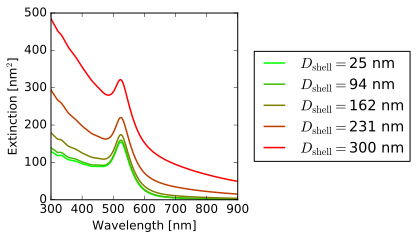

In [115]:
pylab.clf()

exportFlag = True

print('''\
\"mieCextCoreShellArray\" format:
    [   wlnm, 
        rCorenm, 
        rShellnm, nShell, 
        CextCoreShell 
    ] \
''')
mieArray = mieCextCoreShellArray

rCoreListnm = np.sort(np.unique(mieArray[:,1]))
rCorenm = rCoreListnm[0]
print(str(int(round(2*rCorenm))) + ' nm')
rShellListnm = np.unique(mieArray[:,2])
colorList = cm.brg_r(np.linspace(0,0.5,len(rShellListnm)))

xs, ys = [], []
colors, labels = [], []
for shellNum in range(len(rShellListnm)):
    rShellnm = rShellListnm[shellNum]
    color = colorList[shellNum]
    label = '$D_{\mathrm{shell}} = $' + str(int(round(2*rShellnm))) + ' nm'
    subArray = mieArray[( (mieArray[:,1] == rCorenm)
                        & (mieArray[:,2] == rShellnm))]
    subArray = subArray[np.argsort( subArray[:,0] )]
    x, y = subArray[:,0], subArray[:,-1]
    xs.append(x), ys.append(y)
    colors.append(color), labels.append(label)

## Plot lines & set limits
nSets = len(xs)
for setNum in range(nSets):
    pylab.plot(xs[setNum], ys[setNum], 
               color=colors[setNum], label=labels[setNum], 
               linewidth=1.5)
x, y = [], []
for setNum in range(nSets):
    for i in range(len(xs[setNum])): 
        x.append(xs[setNum][i]); y.append(ys[setNum][i])
x, y = np.asarray(x), np.asarray(y)
xLimits = [np.amin(x), np.amax(x)]
yLimits = [np.amin(y), np.amax(y)]
dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])

pylab.xlabel('Wavelength [nm]')
pylab.ylabel('Extinction [nm$^2$]')
pylab.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## Save and display
if (exportFlag):
    fig = pylab.gcf()
    wmmList = [85]
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.pdf'
    identifier = '_spectrum-ext-nm2_15-nm-core-shells'
    folder = ''
    for wmm in wmmList:
        fig.set_size_inches(wmm/25.4, wmm/25.4)
        fontSize = min([int(ceil(wmm/5.7)), 12])
        matplotlib.rcParams.update({'font.size': fontSize})
        for text in fig.texts:
            text.set_fontsize(fontSize)
        sizeName = '_' + str(wmm) + 'mm'
        filename = folder + timestamp + identifier + sizeName + exportFormat
        plt.savefig(filename, transparent=True); print("Exported to:\n", filename)
    matplotlib.rcParams['font.size'] = 12

plt.show()

### Normalized

"mieCextCoreShellArray" format:
    [   wlnm, 
        rCorenm, 
        rShellnm, nShell, 
        CextCoreShell 
    ] 
15 nm
Exported to:
 20170320_spectrum-ext-norm_15-nm-core-shells_85mm.pdf


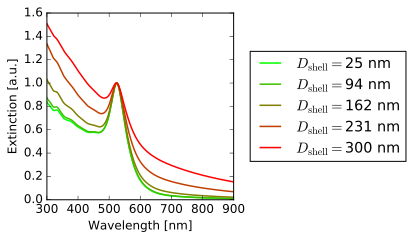

In [118]:
pylab.clf()

exportFlag = True

print('''\
\"mieCextCoreShellArray\" format:
    [   wlnm, 
        rCorenm, 
        rShellnm, nShell, 
        CextCoreShell 
    ] \
''')
mieArray = mieCextCoreShellArray

rCoreListnm = np.unique(mieArray[:,1])
rCorenm = rCoreListnm[0]
print(str(int(round(2*rCorenm))) + ' nm')
rShellListnm = np.unique(mieArray[:,2])
colorList = cm.brg_r(np.linspace(0,0.5,len(rShellListnm)))

xs, ys = [], []
colors, labels = [], []
for shellNum in range(len(rShellListnm)):
    rShellnm = rShellListnm[shellNum]
    color = colorList[shellNum]
    label = '$D_{\mathrm{shell}} = $' + str(int(round(2*rShellnm))) + ' nm'
    subArray = mieArray[( (mieArray[:,1] == rCorenm)
                        & (mieArray[:,2] == rShellnm))]
    subArray = subArray[np.argsort( subArray[:,0] )]
    x, y = subArray[:,0], subArray[:,-1]
    if (len(y) > 0): y = y/max(y[(x > 500)])
    xs.append(x), ys.append(y)
    colors.append(color), labels.append(label)

## Plot lines & set limits
nSets = len(xs)
for setNum in range(nSets):
    pylab.plot(xs[setNum], ys[setNum], 
               color=colors[setNum], label=labels[setNum], 
               linewidth=1.5)
x, y = [], []
for setNum in range(nSets):
    for i in range(len(xs[setNum])): 
        x.append(xs[setNum][i]); y.append(ys[setNum][i])
x, y = np.asarray(x), np.asarray(y)
xLimits = [np.amin(x), np.amax(x)]
yLimits = [np.amin(y), np.amax(y)]
dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])

pylab.xlabel('Wavelength [nm]')
pylab.ylabel('Extinction [a.u.]')
pylab.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## Save and display
if (exportFlag):
    fig = pylab.gcf()
    wmmList = [85]
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.pdf'
    identifier = '_spectrum-ext-norm_15-nm-core-shells'
    folder = ''
    for wmm in wmmList:
        fig.set_size_inches(wmm/25.4, wmm/25.4)
        fontSize = min([int(ceil(wmm/5.7)), 12])
        matplotlib.rcParams.update({'font.size': fontSize})
        for text in fig.texts:
            text.set_fontsize(fontSize)
        sizeName = '_' + str(wmm) + 'mm'
        filename = folder + timestamp + identifier + sizeName + exportFormat
        plt.savefig(filename, transparent=True); print("Exported to:\n", filename)
    matplotlib.rcParams['font.size'] = 12

plt.show()